### ***Critical Data Mining of Media Culture (INFOMCDMMC 2022-2023)***

#### Seminar II 22-11-22 Exercises (in pairs)

 * A) Automated Content Analysis TF-IDF & KMeans Clustering
 
 * B) LDA Topic Modeling
 
 * C) Dictionary-based Content Analysis

##### Imports

In [ ]:
#stats
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import cluster
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy  as np

#support
import re
import html
import datetime
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import json
from os.path import basename
from zipfile import ZipFile
import string
import pickle


#NLP
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nltk.download('stopwords')
lemmatizer = nltk.stem.WordNetLemmatizer()

import spacy
from spacy.symbols import nsubj, VERB
nlp = spacy.load("en_core_web_sm")

from wordcloud import WordCloud

#LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim import corpora, models
from gensim.models import Phrases
from gensim.corpora import Dictionary


#Visualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pprint import pprint

#LDA Visualisation (optional)
import pickle
#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis

#import shifterator as sh
#import networkx as nx
#from collections import defaultdict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

!pip install itables
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

##### A.1) Load and explore the dataset (news_sample.csv or news_sample.p, whatever you fancy)!

In [ ]:
#Load the data file

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1J58MyX58PwTfX2aQ38nWMwC74_djjMYl' -O news_sample.csv
df = pd.read_csv('news_sample.csv',index_col=0)
df.head()



In [ ]:
df.shape

(2000, 8)

##### A.2) Pre-process the news texts and put them in a new column! You may need to convert the columns into the right data type (str) before you can proceeed.

jz: inspect data type of all columns
"object" explain  https://pbpython.com/pandas_dtypes.html


In [ ]:
#First, you need to convert the respective columns into strings - students will run into an error otherwise.
#For more about .astype check https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
df['title'] = df['title'].astype(str)
df['description'] = df['description'].astype(str)
df['body'] = df['body'].astype(str)

In [ ]:
#Function for NLP for separating features (Spacy)
def do_nlp(x):
    doc = nlp(x)
    return doc
    
#Create new column with words separated - this may take a few minutes (on my machine 7-8 min)!
df['text_nlp'] = df['body'].apply(lambda x: do_nlp(x))
df.head()



,outlet,title,keywords,description,datetime,authors,category,body,text_nlp
7780,Wired,How to Watch Movies in Virtual Reality,"['meta', 'netflix', 'amazon prime', 'oculus', ...",Setting up a VR cinema is simple and proves yo...,2022-01-09 07:00:00,['Reece Rogers'],Gear,With bots and console resellers snatching away...,"(With, bots, and, console, resellers, snatchin..."
15708,Guardian,Can we create a moral metaverse?,"['The metaverse', 'Virtual reality', 'Online a...","In the increasingly lifelike worlds of VR, hig...",2022-05-14 14:00:04,['Laurie Clarke'],Technology,Psychotherapist Nina Jane Patel had been on F...,"( , Psychotherapist, Nina, Jane, Patel, had, b..."
11975,NYT,"92nd Street Y to Host Ron Howard, Gwyneth Palt...","['Books', 'Ninety-Second Street Y', 'Gwyneth P...",The 2019-20 season also features appearances b...,2019-07-17 17:00:04,Sara Aridi,Arts,The upcoming season at 92nd Street Y will feat...,"(The, upcoming, season, at, 92nd, Street, Y, w..."
12986,NYT,Steven Spielberg on Storytelling’s Power to Fi...,"['Steven Spielberg', 'Shoah Foundation', 'War ...","The director is reissuing “Schindler’s List,” ...",2018-12-18 20:19:54,Adam Popescu,Arts,"LOS ANGELES — “Pinchas, how old are you?” Stev...","(LOS, ANGELES, —, “, Pinchas, ,, how, old, are..."
5671,Wired,Mass Transit Is in Jeopardy—and So Are Cities,"['public transportation', 'mass transit', 'cit...",Subways and buses are the lifeblood of dense c...,2020-12-14 07:00:00,['Aarian Marshall'],Business,"In the New York City of February 2020, a misse...","(In, the, New, York, City, of, February, 2020,..."


##### A.3) Use Spacy to select features you want to keep/throw out! Does it make sense to keep all features in? Try different combinations and see how the results change later on. [Read more about Spacy here.](https://spacy.io)

In [ ]:
#Function to include text "features" (https://spacy.io/usage/linguistic-features)
def include_features(x):
    include_features = ['VERB', 'PROPN', 'NOUN', 'ADJ'] #see the table below for explaination of tags, try with different combinations
    #text = ' '.join([ent.text for ent in x if ent.tag_ in include_features])
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])   
    return text

df['features'] = df['text_nlp'].apply(lambda x: include_features(x))


In [ ]:
df['features'].head(5)

7780     bots console resellers snatching many people c...
15708    Psychotherapist Nina Jane Patel Facebook Horiz...
11975    upcoming season 92nd Street Y feature ’s celeb...
12986    LOS ANGELES Pinchas old Steven Spielberg asked...
5671     New York City February missed subway train nui...
Name: features, dtype: object

In the table below you can find examples of POS tags

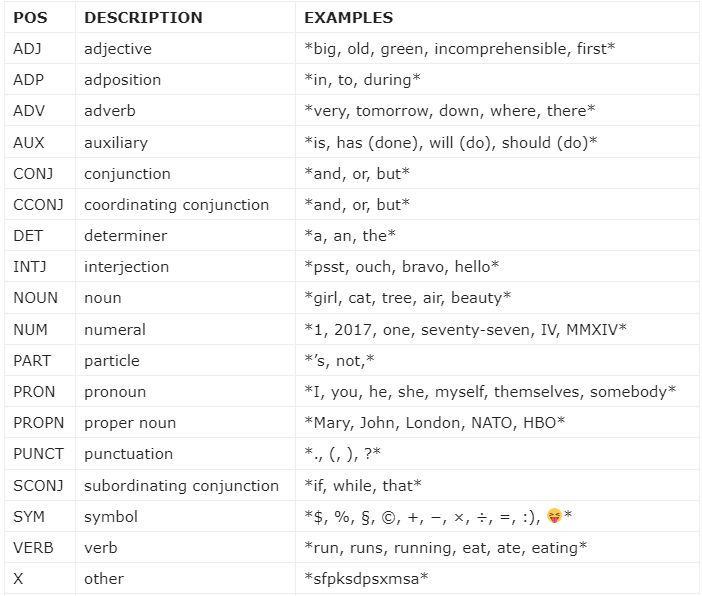

##### A.4) Clean up the texts (lowercase, remove symbols, numbers, stopwords etc.)

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

def clean_text(x):
    x = x.lower()
    re.sub(r'http\S+', '',x) #remove URLs
    x = x.translate(str.maketrans('', '', string.punctuation)) #most punctuations have been removed in step A.3
    # tokenize
    x = nltk.word_tokenize(x) 
    x = [token for token in x if token not in stop_words]
    # lemmatization and pass string back
    x = ' '.join([lemmatizer.lemmatize(w) for w in x])
    return x

stop_words = stopwords.words('english')
new_sw = ['ai', 'artificial intelligence']
stop_words.extend(new_sw)




In [ ]:
df['features'] = df['features'].apply(lambda x: clean_text(x))


##### A.5) Vectorize and calculate TF-IDF!

In [ ]:
#Vectorization tf_idf
vectorizer = TfidfVectorizer(min_df=20, max_df=0.4) #min_df max_df can be float or int
X = vectorizer.fit_transform(df['features'])
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

##### A.6) Calculate KMeans and create a line plot. Find the optimal number of clusters and add column to the dataframe that indicates what clsuter an article belongs to.

In [ ]:

!pip install kneed #not available colab 
from kneed import KneeLocator

In [ ]:
inertia = []

K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0)
    kmeanModel.fit(tf_idf)
    inertia.append(kmeanModel.inertia_)


kn = KneeLocator(K, inertia, curve='convex', direction='decreasing')
print(kn.knee)



8


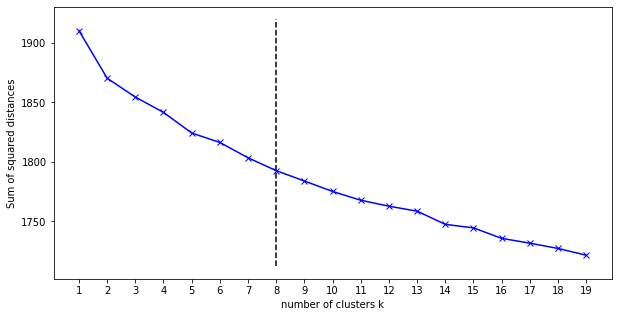

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

plt.xlabel('number of clusters k')
plt.ylabel('Sum of squared distances')
plt.xticks( range(1, 20))
plt.plot(K, inertia, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [ ]:
#Enter recommended number of clusters and add k_means as a new column in the dataframe
clusters = 8
kmeanModel = KMeans(n_clusters=clusters, init='k-means++', max_iter=3000, random_state=0)
mod = kmeanModel.fit_transform(tf_idf)
df['k_means'] = kmeanModel.predict(tf_idf)

##### A.7) Check the top words (e.g., 10 or 15) per cluster. Try labelling the clusters as topics or media frames.

In [ ]:
#Top words per cluster (15, adjust as needed)
order_centroids = kmeanModel.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
dict = []
for i in range(clusters):
    print("%d" % i, sep='', end=','),
    for ind in order_centroids[i, :15]:
        print(terms[ind], sep='', end=',')
    print('')

0,robot,car,machine,job,vehicle,autonomous,driving,computer,worker,student,driver,self,software,university,learning,
1,nan,found,computer,amazon,account,government,american,site,next,place,book,group,robot,service,power,
2,game,player,play,character,alphago,match,playing,console,gaming,video,played,team,tournament,deepmind,xbox,
3,mr,china,trump,chinese,president,government,state,american,nyt,administration,country,business,trade,united,official,
4,content,found,originates,viewed,site,happened,trump,takeaway,war,palmer,theater,president,trailer,sorry,movie,
5,show,film,story,book,movie,science,space,scientist,change,researcher,art,machine,brain,woman,health,
6,google,apple,device,amazon,phone,microsoft,search,assistant,app,feature,cloud,chip,iphone,service,user,
7,facebook,user,platform,twitter,video,content,zuckerberg,group,social,medium,security,law,account,news,government,


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##### A.8) Check the cluster sizes!

In [ ]:
#cluster sizes
df.groupby('k_means').count().reset_index()[['k_means', 'title']]

k_means  title
0        0    259
1        1     39
2        2    115
3        3    222
4        4     25
5        5    858
6        6    239
7        7    243

##### A.9) So far, we've included all articles in our analayis. But what if we want to be stricter in our selection? Find articles that mention the search terms 'A.I./artificial intelligence' at least twice! Create a new dataframe with your selection and repeat the analyses from A.5) to A.8).

In [ ]:
#Function to count occurrences and create new columns with counts
def count_occurences(x):
    pattern = '(a\.i|artificial intelligence|\bai\b)'
    return len(re.findall(pattern, x))

df['title_count'] = df['title'].str.lower().apply(lambda x: count_occurences(x))
df['description_count'] = df['description'].str.lower().apply(lambda x: count_occurences(x))
df['body_count'] = df['body'].str.lower().apply(lambda x: count_occurences(x))


#Create a new dataframe and then just repeat the previous analysis.
selection = df[((df['body_count'] > 1) | (df['description_count'] >= 1) | (df['title_count'] >= 1))].copy()
selection = selection.reset_index()
selection.shape

(394, 16)

##### A.10) Reflect on the TF-IDF approach. What are the benefits, what are the limitations? How can you ensure validity and reliability of the results?

In [ ]:
#answer

##### B.1) Use LDA topic modeling on the news data set. Try it first with all articles and then red-do the process with your stricter selection.

In [ ]:
#There are many different ways to do topic modeling, so the below is just one possible approach!
#The main goal is that students 1) pre-process; 2) choose a justified number of topic; 3) get interpretable results.

#Use the pre-processed text from the dataframes - first try with the full dataset, then the selection
articles = df['features'].copy()
#articles = selection['features'].copy()
articles = articles.reset_index()

##### B.2) Tokenize the texts.

In [ ]:
#Tokenize the texts - there are different methods that students learned about. This one uses NLTK.
articles['features'] =  articles['features'].apply(word_tokenize)
articles['features'].head()

features
Loading... (need help?)


In [ ]:
#Function to remove words - sometimes when exploring the results, some words make the results less informative. 
#These can be filtered out with this function.
def remove_sw(x):
    # remove stopwords
    x = [token for token in x if not token in stop_words]
    return x

stop_words = stopwords.words('english')

#I noticed some words that messed with the results, so I removed them via stopwords. Students need to figure this out themselves!
new_sw = ['ai', 'artificial intelligence', 'mr', 'fb', 'technology']
stop_words.extend(new_sw)


In [ ]:
articles['features'] = articles['features'].apply(lambda x: remove_sw(x))

In [ ]:
#OPTIONAL STEP! Try with and without to see how the results change.
#For more about n-grams see: https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058
#Add bigrams and trigrams to docs (only ones that appear 50 times or more in this attepmt, which is a random choice).
bigram = Phrases(articles['features'], min_count=50)
for idx in range(len(articles['features'])):
    for token in bigram[articles['features'][idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            articles['features'][idx].append(token)

articles.head()

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


index                                           features
0   7780  [bots, console, resellers, snatching, many, pe...
1  15708  [Psychotherapist, Nina, Jane, Patel, Facebook,...
2  11975  [upcoming, season, 92nd, Street, Y, feature, ’...
3  12986  [LOS, ANGELES, Pinchas, old, Steven, Spielberg...
4   5671  [New, York, City, February, missed, subway, tr...

##### B.3) Calculate coherence scores and see if they can assist in determining the number of clusters. Try with the different datasets, different feature selections, and methods for calculating coherence.

In [ ]:
#Use a function for the coherence score, try different coherence metrics ({'u_mass', 'c_v', 'c_uci', 'c_npmi'}, optional) and compare results.
#More info: https://radimrehurek.com/gensim/models/coherencemodel.html
#c_v = the closer to 1, "the better"
#u_mass = the closer to 0, "the better"

#Note: the coherence scores are not great for this dataset! 
#That can have many reasons but also doesn't mean that the results are not interpretable. 
#They can try to tweak the scores by excluding words, changing the feature selection etc.
#The way the news cover the topic in the articles might be rather homogenous.
#In any case, human validation of topics is needed!


In [ ]:
#Function for calculating coherence scores
def coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating for',num_topics,'topics')
        model = LdaModel(corpus=corpus, num_topics=num_topics)
        model_list.append(model)

        #You can adjust the method for coherence here (replace 'c_v' with any other method from the list above)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

#create dictionary
id2word = corpora.Dictionary(articles['features'])

#Create a dictionary representation of the documents.
#dictionary = Dictionary(articles['features'])

#Filter out words that occur in less than 20 documents or more than 50% of the documents. You can experiment with different values here.
id2word.filter_extremes(no_below=10, no_above=0.4)

#Create corpus
corpus = [id2word.doc2bow(doc) for doc in articles['features']]
#corpus = [dictionary.doc2bow(doc) for doc in articles['features']]

start = 5
limit = 20
step = 1

model_list, coherence_values = coherence_values(dictionary=id2word, corpus=corpus, texts=articles['features'], start=start, limit=limit, step=step)


##### B.4) Create a line plot with the coherence scores with number of clusters/topics on the x-axis and the scores on the y-axis. 


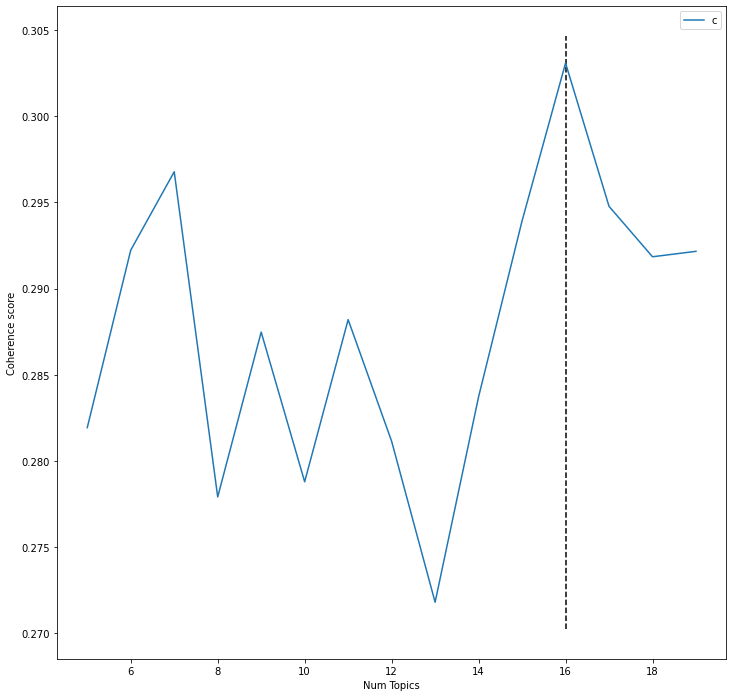

In [ ]:
#Visualise the coherence scores in a plot - there a various ways to create graphs in Python, below we use matplotlib (https://matplotlib.org)
x = range(start, limit, step)
plt.figure(figsize=(12,12))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.vlines(x[np.argmax(coherence_values)], plt.ylim()[0], plt.ylim()[1],linestyles='dashed')
plt.show()

In [ ]:
coherence_values


[0.2819389394219624,
 0.2922341640575246,
 0.2967810372828726,
 0.2779172111341075,
 0.28748059368212225,
 0.2787987295288871,
 0.2882042087202397,
 0.2811479120222862,
 0.27181231250564436,
 0.28372543713320514,
 0.29393061553936295,
 0.30308495606805996,
 0.29477593665001073,
 0.2918499177400913,
 0.2921650774737842]

##### B.5) Create a list of the coherence values.

In [ ]:
#list the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2819
Num Topics = 6  has Coherence Value of 0.2922
Num Topics = 7  has Coherence Value of 0.2968
Num Topics = 8  has Coherence Value of 0.2779
Num Topics = 9  has Coherence Value of 0.2875
Num Topics = 10  has Coherence Value of 0.2788
Num Topics = 11  has Coherence Value of 0.2882
Num Topics = 12  has Coherence Value of 0.2811
Num Topics = 13  has Coherence Value of 0.2718
Num Topics = 14  has Coherence Value of 0.2837
Num Topics = 15  has Coherence Value of 0.2939
Num Topics = 16  has Coherence Value of 0.3031
Num Topics = 17  has Coherence Value of 0.2948
Num Topics = 18  has Coherence Value of 0.2918
Num Topics = 19  has Coherence Value of 0.2922


##### B.6) Choose a K and do the LDA!

In [ ]:
#Adjust num_topics to nmuber of topics with highest coherence score. Check if the results are intepretable as topics.
#It perfectly fine to try different numbers of topics as coherence score merely offer orientation but do not necessarily indicate clear topics.
model = LdaModel(corpus=corpus, num_topics=16,id2word=id2word)
model.print_topics()

[(0,
  '0.004*"Google" + 0.004*"Mr." + 0.003*"content" + 0.003*"viewed" + 0.002*"companies" + 0.002*"China" + 0.002*"Facebook" + 0.002*"data" + 0.002*"site_originates" + 0.002*"content_viewed"'),
 (1,
  '0.004*"data" + 0.004*"Google" + 0.003*"Facebook" + 0.003*"game" + 0.002*"Mr." + 0.002*"companies" + 0.002*"lot" + 0.002*"working" + 0.002*"Apple" + 0.002*"software"'),
 (2,
  '0.004*"data" + 0.003*"New" + 0.003*"Mr." + 0.002*"AI" + 0.002*"life" + 0.002*"." + 0.002*"go" + 0.002*"human" + 0.002*"percent" + 0.002*"Amazon"'),
 (3,
  '0.002*"companies" + 0.002*"data" + 0.002*"AI" + 0.002*"say" + 0.002*"system" + 0.002*"game" + 0.002*"information" + 0.002*"example" + 0.002*"government" + 0.002*"found"'),
 (4,
  '0.005*"Mr." + 0.004*"game" + 0.003*"Google" + 0.003*"data" + 0.003*"AI" + 0.002*"." + 0.002*"human" + 0.002*"companies" + 0.002*"China" + 0.002*"games"'),
 (5,
  '0.004*"data" + 0.003*"Facebook" + 0.003*"Mr." + 0.003*"." + 0.002*"percent" + 0.002*"companies" + 0.002*"software" + 0.00

##### B.7) Compare the results of TF-IDF and LDA topic modeling. What are the differences? How can you explain them?

In [ ]:
#Note: the LDA results aren't great and there are many reasons for why that could be - preprocessing, the data, the parameters, chosen metrics...
#It is the students' challenge to improve the results and reflect on the process
#I will also tweak this script a bit for better results but there is no single 'correct' answer for these exercises
#What is important is that students understand the impact of their choices along the way and the variability of results

##### B.8) Create a dictionary (JSON) and use it to look for a specific concept that you are interested. Check the lecture slides for examples. Count the occurrences of your concept(s). Mybe you can plot them over time? Reflect on the pros and cons of the dictionary approach.

In [ ]:
#For this exmaple, I use a simple dictionary that links specific "data risks" to keywords that indicate their presence in a text.
#The dictionary approach may appear simplistic or "coarse"/"crude" but has merit for scoping the occurrence of a concept in a corpus if well justified 
#Students can come up with any kind of concept they want to investigate in this way

#Load the json that contains the dictionary
pattern_type = 'risks2'
patterns_file = '/Users/dennisnguyen/Desktop/Countries Tech Twitter/'+pattern_type+'.json'

with open(patterns_file) as json_file:
  patterns_json = json.load(json_file)
  patterns = patterns_json['patterns']

cybercrime_cyberwar = []
infodisorder = []
surveillance = []
bias = []

for p in patterns:
  if p['label'] == 'CyberCrime_Cyberwar':
    cybercrime_cyberwar.append(p['pattern'])
  if p['label'] == 'Information Disorder':
    infodisorder.append(p['pattern'])
  if p['label'] == 'Surveillance':
   surveillance.append(p['pattern'])
  if p['label'] == 'Data Bias':
    bias.append(p['pattern'])
    

#Join the strings into a premature regex expression 
cybercrime_cyberwar = '|'.join(cybercrime_cyberwar)
infodisorder = '|'.join(infodisorder)
surveillance = '|'.join(surveillance)
bias = '|'.join(bias)


#Regex to search for the keywords
regex_cyber = re.compile(f"(?<![a-z])((?<!')|(?<=''))("+cybercrime_cyberwar+")(?![a-z])((?!')|(?=''))")
regex_info = re.compile(f"(?<![a-z])((?<!')|(?<=''))("+infodisorder+")(?![a-z])((?!')|(?=''))")
regex_surv = re.compile(f"(?<![a-z])((?<!')|(?<=''))("+surveillance+")(?![a-z])((?!')|(?=''))")
regex_bias = re.compile(f"(?<![a-z])((?<!')|(?<=''))("+bias+")(?![a-z])((?!')|(?=''))")

#Create new columns with counts per concepts
df['Cybercrime'] = df['body'].str.count(regex_cyber)
df['InformationDisorder'] = df['body'].str.count(regex_info)
df['Surveillance'] = df['body'].str.count(regex_surv)
df['DataBias'] = df['body'].str.count(regex_bias)

df.head()


,outlet,title,keywords,description,datetime,authors,category,body,text_nlp,features,k_means,title_count,description_count,body_count,Cybercrime,InformationDisorder,Surveillance,DataBias
0,Wired,How to Watch Movies in Virtual Reality,"['meta', 'netflix', 'amazon prime', 'oculus', ...",Setting up a VR cinema is simple and proves yo...,2022-01-09 07:00:00,['Reece Rogers'],Gear,With bots and console resellers snatching away...,"(With, bots, and, console, resellers, snatchin...",bot console snatching many people chance purch...,6,0,0,0,0,0,0,0
1,Guardian,Can we create a moral metaverse?,"['The metaverse', 'Virtual reality', 'Online a...","In the increasingly lifelike worlds of VR, hig...",2022-05-14 14:00:04,['Laurie Clarke'],Technology,Psychotherapist Nina Jane Patel had been on F...,"( , Psychotherapist, Nina, Jane, Patel, had, b...",psychotherapist nina jane patel facebook horiz...,5,0,0,0,1,0,0,0
2,NYT,"92nd Street Y to Host Ron Howard, Gwyneth Palt...","['Books', 'Ninety-Second Street Y', 'Gwyneth P...",The 2019-20 season also features appearances b...,2019-07-17 17:00:04,Sara Aridi,Arts,The upcoming season at 92nd Street Y will feat...,"(The, upcoming, season, at, 92nd, Street, Y, w...",upcoming season nd street feature celebrity gu...,6,0,0,1,0,0,0,0
3,NYT,Steven Spielberg on Storytelling’s Power to Fi...,"['Steven Spielberg', 'Shoah Foundation', 'War ...","The director is reissuing “Schindler’s List,” ...",2018-12-18 20:19:54,Adam Popescu,Arts,"LOS ANGELES — “Pinchas, how old are you?” Stev...","(LOS, ANGELES, —, “, Pinchas, ,, how, old, are...",los angeles pinchas old steven spielberg asked...,6,0,0,1,0,0,0,2
4,Wired,Mass Transit Is in Jeopardy—and So Are Cities,"['public transportation', 'mass transit', 'cit...",Subways and buses are the lifeblood of dense c...,2020-12-14 07:00:00,['Aarian Marshall'],Business,"In the New York City of February 2020, a misse...","(In, the, New, York, City, of, February, 2020,...",new york city february missed subway train nui...,2,0,0,0,0,0,0,0


In [ ]:
#Convert counts into binary 1/0 (occures/does not occur) per article
df['Cyberwar & Cybercrime'] =  (df['Cybercrime']>0).astype(int)
df['Information Disorder'] =  (df['InformationDisorder']>0).astype(int)
df['Surveillance & Privacy Invasion'] =  (df['Surveillance']>0).astype(int)
df['Data Bias'] =  (df['DataBias']>0).astype(int)

In [ ]:
#Get number of articles that refer to each concept
print('Cyberwar/Cybercrime count: ', df['Cyberwar & Cybercrime'].sum())
print('Information Disorder count: ', df['InformationDisorder'].sum())
print('Surveillance count: ', df['Surveillance & Privacy Invasion'].sum())
print('Data bias count: ', df['Data Bias'].sum())

Cyberwar/Cybercrime count:  315
Information Disorder count:  149
Surveillance count:  350
Data bias count:  313


In [ ]:
#Note: This part still needs some minor debugging!

#Convert string date-time to datetime
df2 = df[['datetime','Cyberwar & Cybercrime', 'Information Disorder', 'Surveillance & Privacy Invasion', 'Data Bias']]
df2['datetime'] = pd.to_datetime(df2['datetime'], errors ='coerce') #not very elegant but well...

#Get just the year 
df2["year"] = df2["datetime"].dt.year

#Group by Year
df2.groupby([df2["datetime"].dt.year])[['datetime','Cyberwar & Cybercrime', 'Information Disorder', 'Surveillance & Privacy Invasion', 'Data Bias']].sum()


/var/folders/x_/mx8j7y5d0291_gfhzd_j9v0h0000gn/T/ipykernel_1905/2443974103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['datetime'] = pd.to_datetime(df2['datetime'], errors ='coerce') #not very elegant but well...
/var/folders/x_/mx8j7y5d0291_gfhzd_j9v0h0000gn/T/ipykernel_1905/2443974103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["year"] = df2["datetime"].dt.year


,Cyberwar & Cybercrime,Information Disorder,Surveillance & Privacy Invasion,Data Bias
datetime,,,,
2002.0,0,0,0,0
2004.0,0,0,0,0
2005.0,1,0,0,0
2006.0,2,0,0,1
2007.0,3,0,0,0
2008.0,0,0,2,3
2009.0,1,0,1,0
2010.0,3,0,1,2
2011.0,0,0,1,1


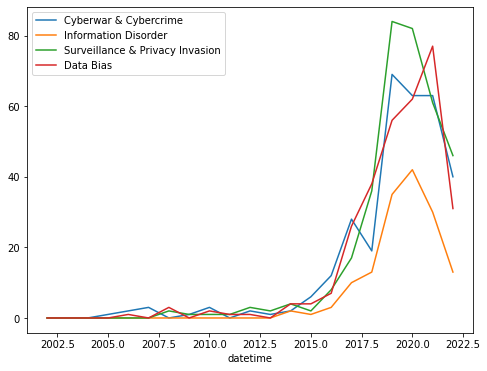

In [ ]:
graph = df2.groupby([df2["datetime"].dt.year])[['Cyberwar & Cybercrime', 'Information Disorder', 'Surveillance & Privacy Invasion', 'Data Bias']].sum().plot(kind='line', figsize = (8, 6))